In [ ]:
import requests, datetime, time, json

def urlPublico(year, month, day):
    return "https://arquivo.pt/wayback/cdx?url=publico.pt/{year:04d}/{month:02d}/{day:02d}/&matchType=prefix&output=json".format(year = year, month = month, day = day)

output = []

start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2021, 1, 5)
date = start_date

while (date < end_date):
    if (date.day == 1):
        print(date)
    r = requests.get(url = urlPublico(date.year, date.month, date.day))
    if (r.status_code == 200 and r.text != ""):
        for line in r.text.split('\n'):
            if (line != ""):
                output.append(json.loads(line))
    elif (r.status_code == 429):
        print("Reached threshold. Waiting 10 seconds")
        time.sleep(10)
    date = date + datetime.timedelta(days = 1)

results = {"publico" : output}

In [ ]:
for identifier, result in results.items():
    print("site: {0}\t noticias: {1}".format(identifier, len(result)))

In [13]:
# Clear repeated news
news = {}
number_of_indexations = {}

for identifier, result in results.items():
    for link in result:
        splitted_url = link['url'].split('/')
        if (len(splitted_url) < 9): # not news
            continue
        tittle = splitted_url[8]
        if ("." in tittle): # not news
            continue
        if (news.get(tittle) == None):
            news[tittle] = link
            number_of_indexations[tittle] = 1
        else:
            number_of_indexations[tittle] += 1


In [14]:
print(len(news))

297


In [19]:
websites = {}

def create_website_link(url, timestamp):
    return "https://arquivo.pt/noFrame/replay/{0}/{1}".format(timestamp, url)

for tittle, link in news.items():
    response = requests.get(create_website_link(link['url'], link['timestamp']))
    websites[tittle] = response.text

# len between 372500 and 37599 might be 404 page


297
{'urlkey': 'pt,publico)/2021/01/01/culturaipsilon/noticia/amigo-cunhal-compagnon-route-pcp-apoiante-costa-1944794', 'timestamp': '20210101201956', 'url': 'https://www.publico.pt/2021/01/01/culturaipsilon/noticia/amigo-cunhal-compagnon-route-pcp-apoiante-costa-1944794', 'mime': 'text/html', 'status': '200', 'digest': 'J4UYV2C25UFRT3QUBCSLGWIDV6J6WMLO', 'length': '75414', 'offset': '39345905', 'filename': 'raq-projetos-fct-2019-20210101201455914-01267-12kmyp7e.warc.gz', 'collection': 'EAWP34', 'source': '$root:EAWP34.cdxj', 'source-coll': '$root'}
36
<!doctype html>
<html class="no-js user--anonymous" lang="pt">
<head><!-- WB Insert -->
<script>
  wbinfo = {};
  wbinfo.top_url = "https://arquivo.pt/noFrame/replay/20210101201956/https://www.publico.pt/2021/01/01/culturaipsilon/noticia/amigo-cunhal-compagnon-route-pcp-apoiante-costa-1944794";
  wbinfo.url = "https://www.publico.pt/2021/01/01/culturaipsilon/noticia/amigo-cunhal-compagnon-route-pcp-apoiante-costa-1944794";
  wbinfo.times
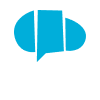

In [21]:
print(len(websites))
print(news['amigo-cunhal-compagnon-route-pcp-apoiante-costa-1944794'])
print(number_of_indexations['amigo-cunhal-compagnon-route-pcp-apoiante-costa-1944794'])
print(websites.get('amigo-cunhal-compagnon-route-pcp-apoiante-costa-1944794'))